In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import numpy as np

# Download & Extract Dataset

In [5]:
#Download the dataset
!wget https://urldefense.com/v3/__http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz__;!!Mih3wA!QXuNlTDEjeooCe7ejtbc-sPw_6iRyiXn00kIIinErwMxQd1HlsfxfuZQVFbRzA$ 

--2021-02-14 19:50:46--  https://urldefense.com/v3/__http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz*5Cn__;JQ!!Mih3wA!QXuNlTDEjeooCe7ejtbc-sPw_6iRyiXn00kIIinErwMxQd1HlsfxfuaiCxmw1g$ Resolving web.ucsd.edu (web.ucsd.edu)... 132.239.1.231, 132.239.1.230
Connecting to web.ucsd.edu (web.ucsd.edu)|132.239.1.231|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 186594679 (178M) [application/x-gzip]
Saving to: ‘meta_Electronics.json.gz’

meta_Electronics.js 100%[===================>] 177.95M  13.9MB/s    in 9.7s    

2021-02-14 19:50:56 (18.4 MB/s) - ‘meta_Electronics.json.gz’ saved [186594679/186594679]



In [37]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

#To pandas dataframe
df = getDF('meta_Electronics.json.gz')

# Cleaning

In [38]:
df = df.dropna()

In [39]:
#Only keep rows with "Also Bought" in the related column
df.related = df.related.apply(lambda x: x if 'also_bought' in x.keys() else np.nan)

In [40]:
df = df.dropna()

In [41]:
#Create also_bought column
df['also_bought'] = df.related.apply(lambda x: x['also_bought'])

#Remove all product IDs (ASINs) outside the dataset
df['also_bought'] = df['also_bought'].apply(lambda x: set(df.asin).intersection(x))

df['also_bought'] = df['also_bought'].apply(lambda x: list(x) if len(x) > 0 else np.nan)

df = df.dropna().reset_index(drop=True)

In [42]:
#Finds Niche Category of each product
df['niche'] = df.categories.apply(lambda x: str(x).strip(']').split(',')[-1])

In [43]:
text_df = df[['asin','description','title']]

In [44]:
text_df.to_json('elec_text.json')
df.to_json('elec_df.json')

text_df.to_csv('elec_text.csv')
df.to_csv('elec_df.csv')

In [12]:
df.categories.apply(lambda x: str(x).strip(']').split(',')[-1])

0                 'Docking Stations'
1         'TV Ceiling & Wall Mounts'
2                    'eBook Readers'
3                    'eBook Readers'
4                          'Tablets'
                    ...             
22331                         'Hubs'
22332           'Bluetooth Car Kits'
22333                     'Monopods'
22334                     'Monopods'
22335          'Chargers & Adapters'
Name: categories, Length: 22336, dtype: object

In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import numpy as np

In [47]:
text_df

,Unnamed: 0,asin,description,title
0,0,0594296420,If you prefer to charge your NOOK Simple Touch...,Barnes &amp; Noble NOOK Simple Touch Wall Adap...
1,1,0972683275,The VideoSecu TV mount is a mounting solution ...,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...
2,2,1400699894,Our Best Reading Experience Yet\nEnjoy crisper...,NOOK GLOWLIGHT eBook Reader 4GB (BNRV500)
3,3,1400532736,The NOOK Simple Touch eReader allows you to re...,Nook Simple Touch eReader
4,4,1400699169,Immerse on an interactive multimedia entertain...,NOOK HD+ 9&quot; 32GB Tablet
...,...,...,...,...
22331,22331,B00L2442H0,Description:Add up to 4 peripherals quickly an...,Sabrent 4 Port Portable USB 2.0 Hub (9.5&quot;...
22332,22332,B00L26YDA4,Description:The Sabrent Wifi Receiver lets you...,Sabrent Wifi Audio Receiver (Supports DLNA and...
22333,22333,B00L34035E,Brand Name: AFUNTABuy as a kit and save! This ...,AFUNTA Extendable Camera Self Selfie Portrait ...
22334,22334,B00L34051Q,Brand Name: AFUNTABuy as a kit and save! This ...,AFUNTA Extendable Camera Self Selfie Portrait ...


In [46]:
text_df = pd.read_csv('elec_text.csv')
df = pd.read_csv('elec_df.csv')

# Text Manipulation

In [113]:
import torch
import torchtext
from torchtext.data import Field
from torchtext.data import TabularDataset
import string

In [167]:
#Tokenize & Preprocess Field Paramaters
tokenize = lambda x: (x.replace('&quot','').translate(str.maketrans('', '', string.punctuation))).split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)

/home/ajarkas/.local/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [168]:
#Upload dataset
text_datafields = [("Unamed", None),("asin", None), ("description", TEXT), ("title", TEXT)]

text_tbl = TabularDataset(
        path="elec_text.csv", # the file path
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=text_datafields)


/home/ajarkas/.local/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/ajarkas/.local/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
examples = text_tbl.examples

In [169]:
#Build Vocab
TEXT.build_vocab(text_tbl)

In [170]:
TEXT.vocab.freqs.most_common(10)

[('the', 63329),
 ('and', 51223),
 ('to', 37744),
 ('for', 31265),
 ('a', 29870),
 ('with', 27613),
 ('of', 23429),
 ('is', 18416),
 ('your', 16388),
 ('in', 15634)]

In [171]:
text_tbl[2].title, 

(['nook', 'glowlight', 'ebook', 'reader', '4gb', 'bnrv500'],)

In [ ]:
#Old

In [16]:
graph_df = df[['asin','categories','title', 'description', 'related']].dropna()

In [17]:
new_related = graph_df.related.apply(lambda x: list(pd.Series(x.values()).explode()))

In [18]:
graph_df.related = new_related

In [20]:
graph_df.to_json('graph_df.json')

In [3]:
graph_df = pd.read_json('graph_df.json')

In [4]:
graph_df

,asin,categories,title,description,related
2,0001048236,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...","[1442300191, 9626349786, 1602837155, 159887916..."
12,0001053744,[[Books]],Pearl and Sir Orfeo,While many readers are familiar with SIR GAWAI...,"[0345277600, 0312248733, 0345277600, 0140442898]"
13,0001055178,[[Books]],Master Georgie,Beryl Bainbridge seems drawn to disaster. Firs...,"[0349116156, 0307947726, 0786702079, 078670146..."
21,0001360000,[[Books]],Mog's Kittens,Judith Kerr&#8217;s best&#8211;selling adventu...,"[0007171285, 0007347049, 0007171331, 000711752..."
42,0001056107,[[Books]],Farmer Giles of Ham: And Other Stories,'A fabulous tale of the days when giants and d...,"[0345518845, 0345357116, 0618009361, 054715411..."
...,...,...,...,...,...
2307866,B00HNAPVUY,"[[Books, Teen & Young Adult]]",ADH058 ADH Publishing - How To Build Tamiya's ...,Features an exhaustive step-by-step guide to c...,"[B00GM2YS80, B001JJZ2FE, B004WBBZWA]"
2321491,B00IASG7QA,[[Books]],Tre Ore: The Seven Last Words of Christ,Father Robert Barron is a Catholic evangelist ...,"[B004MNS076, B000PL1GGG, B0010J34ZI, 161278773..."
2324154,B00IFPZPLG,[[Books]],Where Two Worlds Touch: A Spiritual Journey Th...,"""Any caregiver who has felt duty-bound to supp...","[006202423X, 0809148676, 1940598184, 080413914..."
2340880,B00JDCP8US,[[Books]],Pilates for Menopause on the Reformer,Carolyne Sidhu Anthony has been designing fitn...,"[0976518104, 1447665325, 1491044675, 147832310..."


In [1]:
graph_df

NameError: name 'graph_df' is not defined

In [26]:
rel_nodes = list(graph_df.related.explode())

In [27]:
rel_nodes

['1442300191',
 '9626349786',
 '1602837155',
 '1598879162',
 '1400115159',
 '1478396202',
 '1408426250',
 'B007PM2A4A',
 '1609980603',
 '0312089457',
 '0345277600',
 '0312248733',
 '0345277600',
 '0140442898',
 '0349116156',
 '0307947726',
 '0786702079',
 '0786701463',
 '0786707739',
 'B001IDZK0I',
 '0226743497',
 '0786703229',
 '0802142818',
 '0375700234',
 '0679731369',
 '0812976533',
 '0385722109',
 '1609450868',
 '1416562605',
 'B000GH2YRY',
 '0679777504',
 '1590170180',
 'B001LF2H7W',
 '0374526400',
 '0807608815',
 '1573225436',
 '1609450566',
 'B003H4RCJS',
 '1586420046',
 '0143124870',
 '0571319661',
 '0385474547',
 '0140092552',
 '0316074314',
 '0349116156',
 '1609450868',
 '0307947726',
 'B008SM8T5K',
 '0007171285',
 '0007347049',
 '0007171331',
 '0007117523',
 '0007347030',
 '000717134X',
 '0007228953',
 '0007193661',
 '0007167059',
 '0007171315',
 '0007171366',
 '0007149697',
 '0001374761',
 '0007117523',
 '0007171285',
 '0007171331',
 '0007171366',
 '0345518845',
 '03453571

In [28]:
asin_nodes = list(graph_df.asin )

In [29]:
rel_nodes

['1442300191',
 '9626349786',
 '1602837155',
 '1598879162',
 '1400115159',
 '1478396202',
 '1408426250',
 'B007PM2A4A',
 '1609980603',
 '0312089457',
 '0345277600',
 '0312248733',
 '0345277600',
 '0140442898',
 '0349116156',
 '0307947726',
 '0786702079',
 '0786701463',
 '0786707739',
 'B001IDZK0I',
 '0226743497',
 '0786703229',
 '0802142818',
 '0375700234',
 '0679731369',
 '0812976533',
 '0385722109',
 '1609450868',
 '1416562605',
 'B000GH2YRY',
 '0679777504',
 '1590170180',
 'B001LF2H7W',
 '0374526400',
 '0807608815',
 '1573225436',
 '1609450566',
 'B003H4RCJS',
 '1586420046',
 '0143124870',
 '0571319661',
 '0385474547',
 '0140092552',
 '0316074314',
 '0349116156',
 '1609450868',
 '0307947726',
 'B008SM8T5K',
 '0007171285',
 '0007347049',
 '0007171331',
 '0007117523',
 '0007347030',
 '000717134X',
 '0007228953',
 '0007193661',
 '0007167059',
 '0007171315',
 '0007171366',
 '0007149697',
 '0001374761',
 '0007117523',
 '0007171285',
 '0007171331',
 '0007171366',
 '0345518845',
 '03453571

In [31]:
len(set(asin_nodes).intersection(set(rel_nodes)))

598301

In [32]:
all_nodes = pd.Series(rel_nodes + asin_nodes).unique()xx

In [33]:
len(all_nodes)

1938318

In [9]:
dict_df = graph_df.copy()
dict_df.index = dict_df.asin
adj_nodes = dict_df['related'].to_dict()

In [10]:
adj_nodes = dict_df['related'].to_dict()

In [19]:
len(all_nodes)

5697

In [11]:
edges_tuple = []
for n in adj_nodes.keys():
    for i in adj_nodes[n]:
        edges_tuple.append((n,i))

In [12]:
edges_tuple

[('0001048236', '1442300191'),
 ('0001048236', '9626349786'),
 ('0001048236', '1602837155'),
 ('0001048236', '1598879162'),
 ('0001048236', '1400115159'),
 ('0001048236', '1478396202'),
 ('0001048236', '1408426250'),
 ('0001048236', 'B007PM2A4A'),
 ('0001048236', '1609980603'),
 ('0001048236', '0312089457'),
 ('0000401048', '068240103X'),
 ('0001019880', 'B003HMB5FC'),
 ('0001019880', '0834004593'),
 ('0001019880', '031095360X'),
 ('0001019880', '0834004577'),
 ('0000913154', '0590429892'),
 ('0000913154', '1114119512'),
 ('0000913154', 'B000HW2YQE'),
 ('0000913154', '0395938473'),
 ('0000913154', '0395428572'),
 ('0000913154', '0449208133'),
 ('0000913154', '0486217094'),
 ('0000913154', '0618233784'),
 ('0000913154', '0486443604'),
 ('0000913154', '1856698769'),
 ('0000913154', '0942364155'),
 ('0000913154', '0936070129'),
 ('0000913154', '0671224549'),
 ('0000913154', '0395938473'),
 ('0000913154', 'B000GP0CT8'),
 ('0000913154', '0590429892'),
 ('0000913154', '1114119512'),
 ('00010

In [13]:
import networkx as nx
G = nx.Graph()

In [14]:
G.add_nodes_from(all_nodes)

In [15]:
G.add_edges_from(edges_tuple)

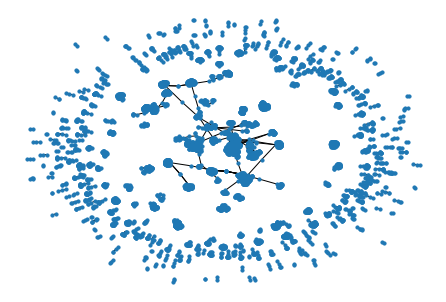

In [18]:
import matplotlib.pyplot as plt
pos=nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=False, node_size= 10)
plt.draw()

In [ ]:
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(df5))

In [ ]:
# how those unformatted rows look like
df4.iloc[0]

In [ ]:
df4.also_view